In [1]:
# packges
import tensorflow as tf
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
import gc

from pandas.plotting import lag_plot
import matplotlib.pyplot as plt
import seaborn as sns
#import plotly.express as px
#import plotly.graph_objects as go
colorMap = sns.light_palette("blue", as_cmap=True)

from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score, mean_absolute_error, f1_score, confusion_matrix

from keras.models import Sequential, Model
from keras.layers import Dense, Input

from keras.layers import LSTM
from keras.layers import Dropout
from keras import metrics
from sklearn.preprocessing import MinMaxScaler

This notebook is primarily focused on implementing the linear, logistic, and neural network models for the Machine Learning Final project. There is also hyperparameter tuning conducted for the neural network model. 

Contributed by Hira Nadeem. 

# Data Loading and Preprocessing

In [2]:
# read dataset
df_train = pd.read_csv('train.csv', index_col='ts_id')


/Users/hiranadeem/anaconda3/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [3]:
# take a look at the dataset and plot it
df_train.head(5)

date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
ts_id                                                                      
0         0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1         0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2         0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3         0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4         0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   

       feature_0  feature_1  feature_2  ...  feature_120  feature_121  \
ts_id                                   ...                             
0              1  -1.872746  -2.191242  ...          NaN          NaN   
1             -1  -1.349537  -1.704709  ...          NaN          NaN   
2             -1   0.812780  -0.256156  ...          NaN          NaN   
3             -1   1.174378   0.344640  ...          NaN          NaN   
4              1  -3.172026  -3.093182  ...          NaN          NaN   

       feature_122  feature_123  feature_124  feature_125  feature_126  \
ts_id                                                                    
0         1.168391     8.313583     1.782433    14.018213     2.653056   
1        -1.178850     1.777472    -0.915458     2.831612    -1.417010   
2         6.115747     9.667908     5.542871    11.671595     7.281757   
3         2.838853     0.499251     3.033732     1.513488     4.397532   
4         0.344850     4.101145     0.614252     6.623456     0.800129   

       feature_127  feature_128  feature_129  
ts_id                                         
0        12.600292     2.301488    11.445807  
1         2.297459    -1.304614     1.898684  
2        10.060014     6.638248     9.427299  
3         1.266037     3.856384     1.013469  
4         5.233243     0.362636     3.926633  

[5 rows x 137 columns]

In [4]:
# resp - resp4, total 5 collumns are what we need to predict
df_train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2390491 entries, 0 to 2390490
Data columns (total 137 columns):
 #    Column       Dtype  
---   ------       -----  
 0    date         int64  
 1    weight       float64
 2    resp_1       float64
 3    resp_2       float64
 4    resp_3       float64
 5    resp_4       float64
 6    resp         float64
 7    feature_0    int64  
 8    feature_1    float64
 9    feature_2    float64
 10   feature_3    float64
 11   feature_4    float64
 12   feature_5    float64
 13   feature_6    float64
 14   feature_7    float64
 15   feature_8    float64
 16   feature_9    float64
 17   feature_10   float64
 18   feature_11   float64
 19   feature_12   float64
 20   feature_13   float64
 21   feature_14   float64
 22   feature_15   float64
 23   feature_16   float64
 24   feature_17   float64
 25   feature_18   float64
 26   feature_19   float64
 27   feature_20   float64
 28   feature_21   float64
 29   feature_22   float64
 30   feature_23   flo

In [5]:
# clean NaN and check % missing value in the tatal dataset
missing = df_train.isnull().sum().sum()
total_numbers = np.product(df_train.shape)
print("NaN/Total ===> ",(missing/total_numbers) * 100, "%")

NaN/Total ===>  2.0649641024332577 %


In [6]:
del missing
del total_numbers
gc.collect()

30

In [7]:
# So, there're only 2.06% missing values. I decided to replace it with -999.(searched online, and find this way to deal with NaN)
spi = SimpleImputer(missing_values=np.nan, strategy='mean')
spi = spi.fit(df_train.values)
imputed_data = spi.transform(df_train.values)

In [8]:
imputed_data = pd.DataFrame(imputed_data, columns=df_train.columns)
imputed_data.head(6)

date     weight    resp_1    resp_2    resp_3    resp_4      resp  \
0   0.0   0.000000  0.009916  0.014079  0.008773  0.001390  0.006270   
1   0.0  16.673515 -0.002828 -0.003226 -0.007319 -0.011114 -0.009792   
2   0.0   0.000000  0.025134  0.027607  0.033406  0.034380  0.023970   
3   0.0   0.000000 -0.004730 -0.003273 -0.000461 -0.000476 -0.003200   
4   0.0   0.138531  0.001252  0.002165 -0.001215 -0.006219 -0.002604   
5   0.0   0.000000 -0.001047 -0.002700  0.000743  0.004667  0.001282   

   feature_0  feature_1  feature_2  ...  feature_120  feature_121  \
0        1.0  -1.872746  -2.191242  ...     0.335127     0.268776   
1       -1.0  -1.349537  -1.704709  ...     0.335127     0.268776   
2       -1.0   0.812780  -0.256156  ...     0.335127     0.268776   
3       -1.0   1.174378   0.344640  ...     0.335127     0.268776   
4        1.0  -3.172026  -3.093182  ...     0.335127     0.268776   
5       -1.0  -1.499681  -1.928023  ...     0.335127     0.268776   

   feature_122  feature_123  feature_124  feature_125  feature_126  \
0     1.168391     8.313583     1.782433    14.018213     2.653056   
1    -1.178850     1.777472    -0.915458     2.831612    -1.417010   
2     6.115747     9.667908     5.542871    11.671595     7.281757   
3     2.838853     0.499251     3.033732     1.513488     4.397532   
4     0.344850     4.101145     0.614252     6.623456     0.800129   
5     0.337112     4.079450     0.613967     6.622410     0.799525   

   feature_127  feature_128  feature_129  
0    12.600292     2.301488    11.445807  
1     2.297459    -1.304614     1.898684  
2    10.060014     6.638248     9.427299  
3     1.266037     3.856384     1.013469  
4     5.233243     0.362636     3.926633  
5     5.231833     0.360831     3.922324  

[6 rows x 137 columns]

In [9]:
missing = imputed_data.isnull().sum().sum()
total_numbers = np.product(imputed_data.shape)
df_cleaned = imputed_data.copy()
print("After imputing % ===> ",(missing/total_numbers) * 100, "%")

After imputing % ===>  0.0 %


In [10]:
del missing
del total_numbers
del imputed_data
del spi
gc.collect()

60

In [13]:
# According to https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation 
# And example_sample_submission.csv only contains ts_id and action, action means if we make the deal or not
# So, for our project, we calculate the action before training and taking it as the target. 
# Finally, we'll use 'action' to get the acc. (spliting the data into 30% as test set)
# here's our code
# NOTE: we got this approach by plotting the dataset and compare the resp and time. 
# We changed the order of the notebook, and put the visualization part after calculating 'action'

In [11]:
df_cleaned['action'] = ((df_cleaned['weight'].values * df_cleaned['resp'].values) > 0).astype('int')
df_cleaned.action.head(20)

0     0
1     0
2     0
3     0
4     0
5     0
6     1
7     1
8     0
9     1
10    0
11    0
12    0
13    0
14    0
15    0
16    1
17    1
18    1
19    0
Name: action, dtype: int64

In [15]:
# here, we got the target and the next step is to SPLIT and VISUALIZE it

In [12]:
# data split ---> train_X, train_y, test_X, test_y
Y = df_cleaned[['action']]
X = df_cleaned.drop(['weight','resp','resp_1','resp_2','resp_3','resp_4', 'action'], axis=1)

In [13]:
Y = df_cleaned[['action']]
X = df_cleaned.drop(['weight','resp','resp_1','resp_2','resp_3','resp_4', 'action'], axis=1)

In [14]:
train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.33, random_state=6)

In [15]:
del df_cleaned
gc.collect()

75

In [16]:
# sort them, better visualizing
train_X = train_X.sort_index()
train_y = train_y.sort_index()

In [17]:
test_X = test_X.sort_index()
test_y = test_y.sort_index()

In [200]:
# ts_id is the order of each row, sorted by date
# compare the trend of different resp on different date
# output 5 plots
'''
resps = ['resp','resp_1','resp_2','resp_3','resp_4']
for r in resps:
    fig, ax = plt.subplots(figsize=(15, 5))
    balance= pd.Series(df_train[r])
    ax.set_xlabel ("Trade", fontsize=18)
    ax.set_ylabel (r, fontsize=18);
    balance.plot(lw=3);
'''

'\nresps = [\'resp\',\'resp_1\',\'resp_2\',\'resp_3\',\'resp_4\']\nfor r in resps:\n    fig, ax = plt.subplots(figsize=(15, 5))\n    balance= pd.Series(df_train[r])\n    ax.set_xlabel ("Trade", fontsize=18)\n    ax.set_ylabel (r, fontsize=18);\n    balance.plot(lw=3);\n    '

In [198]:
# Cumulative resps in one plot 
'''
fig, ax = plt.subplots()
resp= pd.Series(df_train['resp']).cumsum()
resp_1= pd.Series(df_train['resp_1']).cumsum()
resp_2= pd.Series(df_train['resp_2']).cumsum()
resp_3= pd.Series(df_train['resp_3']).cumsum()
resp_4= pd.Series(df_train['resp_4']).cumsum()
ax.set_xlabel ("Trade", fontsize=10)
ax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)
resp.plot(lw=3)
resp_1.plot(lw=3)
resp_2.plot(lw=3)
resp_3.plot(lw=3)
resp_4.plot(lw=3)
plt.legend()
'''

'\nfig, ax = plt.subplots()\nresp= pd.Series(df_train[\'resp\']).cumsum()\nresp_1= pd.Series(df_train[\'resp_1\']).cumsum()\nresp_2= pd.Series(df_train[\'resp_2\']).cumsum()\nresp_3= pd.Series(df_train[\'resp_3\']).cumsum()\nresp_4= pd.Series(df_train[\'resp_4\']).cumsum()\nax.set_xlabel ("Trade", fontsize=10)\nax.set_title ("Cumulative resp and time horizons 1, 2, 3, and 4 (500 days)", fontsize=18)\nresp.plot(lw=3)\nresp_1.plot(lw=3)\nresp_2.plot(lw=3)\nresp_3.plot(lw=3)\nresp_4.plot(lw=3)\nplt.legend()\n'

In [197]:
# weight over time(ts_id)
'''
fig, ax = plt.subplots(figsize=(15,6))
resp= pd.Series(df_train['weight'])
ax.set_xlabel ("TS-ID", fontsize=20)
ax.set_ylabel ("Weight", fontsize=20);
resp.plot(lw=3);
'''

'\nfig, ax = plt.subplots(figsize=(15,6))\nresp= pd.Series(df_train[\'weight\'])\nax.set_xlabel ("TS-ID", fontsize=20)\nax.set_ylabel ("Weight", fontsize=20);\nresp.plot(lw=3);\n'

In [18]:
# clean ram
gc.collect()

45

In [19]:
df_features = pd.read_csv('features.csv')

In [20]:
df_features.feature

0        feature_0
1        feature_1
2        feature_2
3        feature_3
4        feature_4
          ...     
125    feature_125
126    feature_126
127    feature_127
128    feature_128
129    feature_129
Name: feature, Length: 130, dtype: object

In [21]:
df_train.describe()

date        weight        resp_1        resp_2        resp_3  \
count  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06   
mean   2.478668e+02  3.031535e+00  1.434969e-04  1.980749e-04  2.824183e-04   
std    1.522746e+02  7.672794e+00  8.930163e-03  1.230236e-02  1.906882e-02   
min    0.000000e+00  0.000000e+00 -3.675043e-01 -5.328334e-01 -5.681196e-01   
25%    1.040000e+02  1.617400e-01 -1.859162e-03 -2.655044e-03 -5.030704e-03   
50%    2.540000e+02  7.086770e-01  4.552665e-05  6.928179e-05  1.164734e-04   
75%    3.820000e+02  2.471791e+00  2.097469e-03  2.939111e-03  5.466336e-03   
max    4.990000e+02  1.672937e+02  2.453477e-01  2.949339e-01  3.265597e-01   

             resp_4          resp     feature_0     feature_1     feature_2  \
count  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06  2.390491e+06   
mean   4.350201e-04  4.083113e-04  9.838565e-03  3.855776e-01  3.576875e-01   
std    3.291224e-02  2.693609e-02  9.999518e-01  2.559373e+00  2.477335e+00   
min   -5.987447e-01 -5.493845e-01 -1.000000e+00 -3.172026e+00 -3.093182e+00   
25%   -9.310415e-03 -7.157903e-03 -1.000000e+00 -1.299334e+00 -1.263628e+00   
50%    1.222579e-04  8.634997e-05  1.000000e+00 -1.870182e-05 -7.200577e-07   
75%    9.804649e-03  7.544347e-03  1.000000e+00  1.578417e+00  1.526399e+00   
max    5.113795e-01  4.484616e-01  1.000000e+00  7.442989e+01  1.480763e+02   

       ...   feature_120   feature_121   feature_122   feature_123  \
count  ...  2.320637e+06  2.320637e+06  2.390268e+06  2.390268e+06   
mean   ...  3.351270e-01  2.687757e-01  3.435523e-01  2.799973e-01   
std    ...  1.906376e+00  2.174238e+00  2.087842e+00  1.977643e+00   
min    ... -4.883486e+00 -7.471971e+00 -5.862979e+00 -6.029281e+00   
25%    ... -1.024422e+00 -1.123252e+00 -1.114326e+00 -9.512009e-01   
50%    ...  0.000000e+00  0.000000e+00  7.006233e-17  6.054629e-17   
75%    ...  1.337221e+00  1.342829e+00  1.405926e+00  1.308625e+00   
max    ...  6.573832e+01  1.107771e+02  4.812516e+01  1.276908e+02   

        feature_124   feature_125   feature_126   feature_127   feature_128  \
count  2.374408e+06  2.374408e+06  2.381638e+06  2.381638e+06  2.388570e+06   
mean   3.351537e-01  2.448752e-01  3.391778e-01  2.323809e-01  3.425608e-01   
std    1.742587e+00  2.242853e+00  2.534498e+00  1.795854e+00  2.307130e+00   
min   -4.080720e+00 -8.136407e+00 -8.215050e+00 -5.765982e+00 -7.024909e+00   
25%   -9.133750e-01 -1.212124e+00 -1.452912e+00 -8.993050e-01 -1.278341e+00   
50%    4.870826e-17 -2.558675e-16  1.015055e-16  5.419920e-17  8.563069e-17   
75%    1.228277e+00  1.409687e+00  1.767275e+00  1.111491e+00  1.582633e+00   
max    6.514517e+01  7.052807e+01  5.872849e+01  6.932221e+01  5.119038e+01   

        feature_129  
count  2.388570e+06  
mean   2.456182e-01  
std    1.765419e+00  
min   -5.282181e+00  
25%   -8.544535e-01  
50%    4.869529e-17  
75%    1.125321e+00  
max    1.164568e+02  

[8 rows x 137 columns]

# PART1 -----------> Linear and Logistic Regression

A. Linear Regression

In [ ]:
#train_X, test_X, train_y, test_y = train_test_split(X, Y, test_size=0.33, random_state=6)

In [39]:

lr = LinearRegression()
lr.fit(train_X, train_y)
lr_train_pred = lr.predict(train_X)
lr_test_pred = lr.predict(test_X)

# scores
print("LR train MSE:", mean_squared_error(train_y, lr_train_pred)) #best MSE is 0.0
print("LR test MSE:", mean_squared_error(test_y, lr_test_pred))
print("LR train RMSE:", np.sqrt(mean_squared_error(train_y, lr_train_pred))) #best RMSE is 0.0
print("LR test RMSE:", np.sqrt(mean_squared_error(test_y, lr_test_pred)))
print("LR train R2 score:", r2_score(train_y, lr_train_pred)) #best R2 score is 1
print("LR test R2 score:", r2_score(test_y, lr_test_pred))
print("LR train mean absolute error:", mean_absolute_error(train_y, lr_train_pred)) #best MAE is 0.0
print("LR test mean absolute error:", mean_absolute_error(test_y, lr_test_pred)) 

LR train MSE: 0.23748720202421914
LR test MSE: 0.23749705236309523
LR train RMSE: 0.48732658661745426
LR test RMSE: 0.48733669301941057
LR train R2 score: 0.023886522297810187
LR test R2 score: 0.023704002447700323
LR train mean absolute error: 0.47538480864621324
LR test mean absolute error: 0.47532291394580084


In [126]:
c = confusion_matrix(test_y, lr_test_pred.round())
print(c)

[[     0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0]
 [     0      0      0      0      0      0      0]
 [     1      2     15     71 420250  38838      2]
 [     0      0      0      2 289360  40322      0]
 [     0      0      0      0      0      0      0]]


In [137]:
lr_test_pred.reshape(788863,1)

array([[0.35112384],
       [0.2253734 ],
       [0.29976037],
       ...,
       [0.43052224],
       [0.28378997],
       [0.22758925]])

In [100]:
# dataframe LR score
pred = pd.DataFrame(lr_train_pred)
test_pred = pd.DataFrame(lr_test_pred)


B. Logistic Regression

In [51]:
logreg = LogisticRegression(max_iter=2000)
logreg.fit(train_X, train_y['action'])

LogisticRegression(max_iter=2000)

In [52]:
y_pred = logreg.predict(test_X)
y_tr_pred = logreg.predict(train_X)
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(test_X, test_y)))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logreg.score(train_X, train_y)))

Accuracy of logistic regression classifier on test set: 0.58
Accuracy of logistic regression classifier on test set: 0.58


In [53]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(train_y, y_tr_pred)
print(c)

[[825628 106297]
 [561823 107880]]


In [54]:
print("% of correct predictions:", ((407169+52758) / (459927+328936))*100, "%" )
print("% of incorrect predictions:", ((276926+52010)/ (459927+328936))*100, "%")

% of correct predictions: 58.30251894181879 %
% of incorrect predictions: 41.69748105818121 %


In [55]:

print("Logistic Regression F1 score:", f1_score(test_y, y_pred))

# F1 score is best at 1 and worst at 0 --> this is not a great score

Logistic Regression F1 score: 0.24287147947299126


In [57]:
from sklearn.metrics import recall_score, precision_score
print("Logistic Regression Recall score:", recall_score(test_y, y_pred))

Logistic Regression Recall score: 0.16002596425668217


In [58]:
print("Logistic Regression Precision score:", precision_score(test_y, y_pred))

Logistic Regression Precision score: 0.5035697923029933


In [147]:

print("Logistic Regression R2 score:", r2_score(test_y, y_pred))
print("Logistic Regression R2 score:", r2_score(train_y, y_tr_pred))

#negative r2 score means we are doing worse than taking the mean value

Logistic Regression R2 score: -0.71408796277932
Logistic Regression R2 score: -0.7145609108517925


In [150]:
print("Logistic Regression MSE:", mean_squared_error(test_y, y_pred))
print("Logistic Regression RMSE:", np.sqrt(mean_squared_error(test_y, y_pred)))
print("Logistic Regression MAE:", mean_absolute_error(test_y, y_pred))


print("Logistic Regression MSE:", mean_squared_error(train_y, y_tr_pred))
print("Logistic Regression RMSE:", np.sqrt(mean_squared_error(train_y, y_tr_pred)))

Logistic Regression MSE: 0.41697481058181207
Logistic Regression RMSE: 0.6457358675045177
Logistic Regression MAE: 0.41697481058181207
Logistic Regression MSE: 0.4171505493160709
Logistic Regression RMSE: 0.6458719295000138


# PART2 -----------> NN MODEL

In [22]:
# Data preparation to normalize values before training neural network model - was not used in NN because we ran out of time, added normalization in the RNN with LSTM

train = df_train.query('date > 85').reset_index(drop = True) 
train = train[train['weight'] != 0]
train.fillna(train.mean(),inplace=True)

train['action'] = ((train['resp'].values) > 0).astype(int)


features = [c for c in train.columns if "feature" in c]


f_mean = np.mean(df_train[features[1:]].values,axis=0)

resp_cols = ['resp_1', 'resp_2', 'resp_3', 'resp', 'resp_4']


In [23]:
X_train = train.loc[:, train.columns.str.contains('feature')]
#y_train = (train.loc[:, 'action'])

y_train = np.stack([(train[c] > 0).astype('int') for c in resp_cols]).T

In [24]:
X_nn = train_X[features]
y_nn = train_y.copy()

test_X_nn = test_X[features]
test_y_nn = test_y.copy()

In [25]:
X_mean = X_nn.mean(axis=0)
X_std = X_nn.std(axis=0)
def Normalize(df):
    return (df - X_mean)/X_std
X_nn = Normalize(X_nn)

test_X_mean = test_X_nn.mean(axis=0)
test_X_std = test_X_nn.std(axis=0)
def Normalize(df):
    return (df - test_X_mean)/test_X_std
test_X_nn = Normalize(test_X_nn)

In [26]:
print(X_nn.shape, test_X_nn.shape)
X_nn = X_nn.values.reshape((X_nn.shape[0], 1, X_nn.shape[1]))
test_X_nn = test_X_nn.values.reshape((test_X_nn.shape[0], 1, test_X_nn.shape[1]))
print(X_nn.shape, test_X_nn.shape)

(1601628, 130) (788863, 130)
(1601628, 1, 130) (788863, 1, 130)


In [177]:
X_nn.shape

(1601628, 1, 130)

In [27]:
# Implementing NN Model

NNmodel = Sequential()
NNmodel.add(Dense(131, input_shape=train_X.shape, activation='relu')) # change the output layer size based on https://stackoverflow.com/questions/56299770/units-in-dense-layer-in-keras
NNmodel.add(Dense(65, activation='relu'))
NNmodel.add(Dense(65, activation='relu'))
NNmodel.add(Dense(1, activation='sigmoid'))
NNmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(NNmodel.summary())


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1601628, 131)      17292     
_________________________________________________________________
dense_1 (Dense)              (None, 1601628, 65)       8580      
_________________________________________________________________
dense_2 (Dense)              (None, 1601628, 65)       4290      
_________________________________________________________________
dense_3 (Dense)              (None, 1601628, 1)        66        
Total params: 30,228
Trainable params: 30,228
Non-trainable params: 0
_________________________________________________________________
None


In [29]:
NNhistory = NNmodel.fit(train_X, train_y, validation_data=(test_X, test_y), epochs = 200, batch_size = 4000)

Epoch 1/200
401/401 [==============================] - 5s 12ms/step - loss: 0.6469 - accuracy: 0.5932 - val_loss: 0.6531 - val_accuracy: 0.5797
Epoch 2/200
401/401 [==============================] - 5s 13ms/step - loss: 0.6462 - accuracy: 0.5935 - val_loss: 0.6467 - val_accuracy: 0.5936
Epoch 3/200
401/401 [==============================] - 6s 16ms/step - loss: 0.6454 - accuracy: 0.5940 - val_loss: 0.6482 - val_accuracy: 0.5924
Epoch 4/200
401/401 [==============================] - 5s 12ms/step - loss: 0.6445 - accuracy: 0.5953 - val_loss: 0.6479 - val_accuracy: 0.5901
Epoch 5/200
401/401 [==============================] - 4s 11ms/step - loss: 0.6433 - accuracy: 0.5966 - val_loss: 0.6455 - val_accuracy: 0.5942
Epoch 6/200
401/401 [==============================] - 4s 10ms/step - loss: 0.6435 - accuracy: 0.5961 - val_loss: 0.6466 - val_accuracy: 0.5912
Epoch 7/200
401/401 [==============================] - 4s 10ms/step - loss: 0.6421 - accuracy: 0.5975 - val_loss: 0.6444 - val_accuracy:

In [ ]:
#200 epochs

In [30]:
y_nn_pred = NNmodel.predict(test_X)

In [31]:
y_nn_pred.size

788863

In [32]:
y_tr_nn_pred = NNmodel.predict(train_X)

In [33]:
y_tr_nn_pred.size

1601628

In [34]:
acc_tr_nn = accuracy_score(train_y,y_tr_nn_pred.round())
acc_nn = accuracy_score(test_y,y_nn_pred.round())
print('Accuracy train is:', acc_tr_nn*100)
print('Accuracy is:', acc_nn*100)

Accuracy train is: 62.11748296108709
Accuracy is: 60.2491180344369


In [35]:
from sklearn.metrics import roc_auc_score
loss_train = roc_auc_score(train_y,y_tr_nn_pred.round())
loss_test = roc_auc_score(test_y, y_nn_pred.round())
print("loss of train is:", loss_train)
print("loss of test is:", loss_test)

loss of train is: 0.5673108512151434
loss of test is: 0.5479334100898162


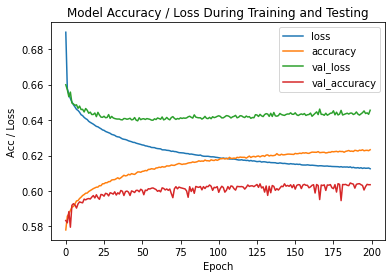

In [186]:
plt.figure()
plt.plot(NNhistory.history['loss'], label='loss')
plt.plot(NNhistory.history['accuracy'], label='accuracy')
plt.plot(NNhistory.history['val_loss'], label='val_loss')
plt.plot(NNhistory.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy / Loss During Training and Testing')
plt.xlabel('Epoch')
plt.ylabel('Acc / Loss')
plt.legend()
plt.show()

Accuracy is: 59.50298087247089


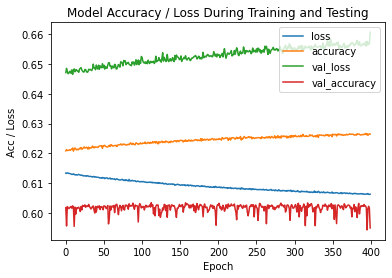

In [53]:
#400 epochs
y_nn_pred = NNmodel.predict(test_X)

acc_nn = accuracy_score(test_y,y_nn_pred.round())
print('Accuracy is:', acc_nn*100)

plt.figure()
plt.plot(NNhistory.history['loss'], label='loss')
plt.plot(NNhistory.history['accuracy'], label='accuracy')
plt.plot(NNhistory.history['val_loss'], label='val_loss')
plt.plot(NNhistory.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy / Loss During Training and Testing')
plt.xlabel('Epoch')
plt.ylabel('Acc / Loss')
plt.legend()
plt.show()

Accuracy train is: 62.15126109183905
Accuracy test is: 60.366502168310596
NN test F1 score: 0.34145385918056126
NN train F1 score: 0.3726211815746878
NN test R2 score: -0.6292423386762334
NN train R2 score: -0.5556486348481011
NN test precision score: 0.5586917562724014
NN train precision score: 0.6070825169542682
NN test recall score: 0.24585663847805778
NN train recall score: 0.26880572432854566


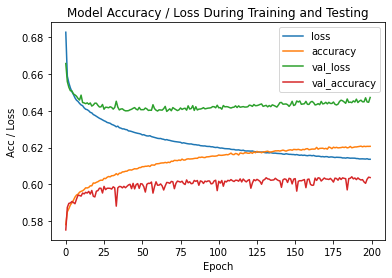

In [202]:
# normal NN

y_nn_pred = NNmodel.predict(test_X)
y_tr_nn_pred = NNmodel.predict(train_X)
acc_tr_nn = accuracy_score(train_y,y_tr_nn_pred.round())
acc_nn = accuracy_score(test_y,y_nn_pred.round())
print('Accuracy train is:', acc_tr_nn*100)
print('Accuracy test is:', acc_nn*100)
print("NN test F1 score:", f1_score(test_y, y_nn_pred.round()))
print("NN train F1 score:", f1_score(train_y, y_tr_nn_pred.round()))
print("NN test R2 score:", r2_score(test_y, y_nn_pred.round()))
print("NN train R2 score:", r2_score(train_y, y_tr_nn_pred.round()))
# The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.
print("NN test precision score:", precision_score(test_y, y_nn_pred.round())) # best is 1, worst is 0
print("NN train precision score:", precision_score(train_y, y_tr_nn_pred.round()))
# The recall is intuitively the ability of the classifier to find all the positive samples.
print("NN test recall score:", recall_score(test_y, y_nn_pred.round())) #best is 1, worst is 0
print("NN train recall score:", recall_score(train_y, y_tr_nn_pred.round()))

plt.figure()
plt.plot(NNhistory.history['loss'], label='loss')
plt.plot(NNhistory.history['accuracy'], label='accuracy')
plt.plot(NNhistory.history['val_loss'], label='val_loss')
plt.plot(NNhistory.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy / Loss During Training and Testing')
plt.xlabel('Epoch')
plt.ylabel('Acc / Loss')
plt.legend()
plt.show()

In [31]:
# 200 epochs, 4000 batch size
NNhistory = NNmodel.fit(train_X, train_y, epochs = 150, batch_size = 4000)

Epoch 1/150
401/401 [==============================] - 3s 7ms/step - loss: 0.6705 - accuracy: 0.5816
Epoch 2/150
401/401 [==============================] - 3s 7ms/step - loss: 0.6545 - accuracy: 0.5863
Epoch 3/150
401/401 [==============================] - 3s 7ms/step - loss: 0.6507 - accuracy: 0.5892
Epoch 4/150
401/401 [==============================] - 3s 7ms/step - loss: 0.6480 - accuracy: 0.5911
Epoch 5/150
401/401 [==============================] - 3s 7ms/step - loss: 0.6464 - accuracy: 0.5927
Epoch 6/150
401/401 [==============================] - 3s 7ms/step - loss: 0.6450 - accuracy: 0.5948
Epoch 7/150
401/401 [==============================] - 3s 7ms/step - loss: 0.6439 - accuracy: 0.5954
Epoch 8/150
401/401 [==============================] - 3s 7ms/step - loss: 0.6426 - accuracy: 0.5959
Epoch 9/150
401/401 [==============================] - 3s 7ms/step - loss: 0.6413 - accuracy: 0.5974
Epoch 10/150
401/401 [==============================] - 3s 7ms/step - loss: 0.6409 - accura

In [32]:
y_nn_pred = NNmodel.predict(test_X)
acc_nn = accuracy_score(test_y,y_nn_pred.round())
print('Accuracy is:', acc_nn*100)

plt.figure()
plt.plot(NNhistory.history['loss'], label='loss')
plt.plot(NNhistory.history['accuracy'], label='accuracy')
plt.title('Model Accuracy / Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Acc / Loss')
plt.legend()
plt.show()

Accuracy is: 60.15303037409537


In [ ]:
#here we tune the batch size

In [213]:
NNmodel = Sequential()
NNmodel.add(Dense(131, input_shape=train_X.shape, activation='relu')) # change the output layer size based on https://stackoverflow.com/questions/56299770/units-in-dense-layer-in-keras
NNmodel.add(Dense(65, activation='relu'))
NNmodel.add(Dense(65, activation='sigmoid'))
NNmodel.add(Dense(1, activation='sigmoid'))
NNmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(NNmodel.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1601628, 131)      17292     
_________________________________________________________________
dense_1 (Dense)              (None, 1601628, 65)       8580      
_________________________________________________________________
dense_2 (Dense)              (None, 1601628, 65)       4290      
_________________________________________________________________
dense_3 (Dense)              (None, 1601628, 1)        66        
Total params: 30,228
Trainable params: 30,228
Non-trainable params: 0
_________________________________________________________________
None


In [69]:
#tune batch size from 1000 to 10000 with epochs to 200
batch_loss = []
batch_acc = []
batches = [1000, 2000, 5000, 7500, 10000]
for batch_size in batches:
    NNhistory = NNmodel.fit(train_X, train_y, epochs = 200, batch_size = batch_size)
    batch_loss.append(NNhistory.history['loss'])
    batch_acc.append(NNhistory.history['accuracy'])

Epoch 1/200
1602/1602 [==============================] - 4s 3ms/step - loss: 0.6183 - accuracy: 0.6165
Epoch 2/200
1602/1602 [==============================] - 4s 3ms/step - loss: 0.6187 - accuracy: 0.6163
Epoch 3/200
1602/1602 [==============================] - 4s 3ms/step - loss: 0.6186 - accuracy: 0.6161
Epoch 4/200
1602/1602 [==============================] - 4s 2ms/step - loss: 0.6184 - accuracy: 0.6163
Epoch 5/200
1602/1602 [==============================] - 4s 3ms/step - loss: 0.6185 - accuracy: 0.6163
Epoch 6/200
1602/1602 [==============================] - 4s 3ms/step - loss: 0.6184 - accuracy: 0.6162
Epoch 7/200
1602/1602 [==============================] - 4s 3ms/step - loss: 0.6184 - accuracy: 0.6163
Epoch 8/200
1602/1602 [==============================] - 4s 3ms/step - loss: 0.6186 - accuracy: 0.6160
Epoch 9/200
1602/1602 [==============================] - 4s 3ms/step - loss: 0.6188 - accuracy: 0.6160
Epoch 10/200
1602/1602 [==============================] - 4s 2ms/step - l

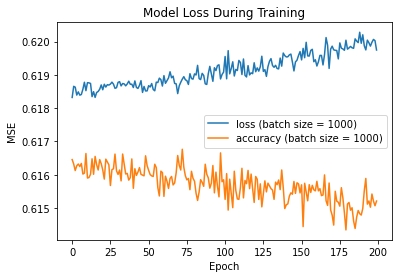

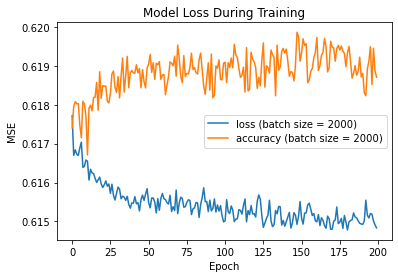

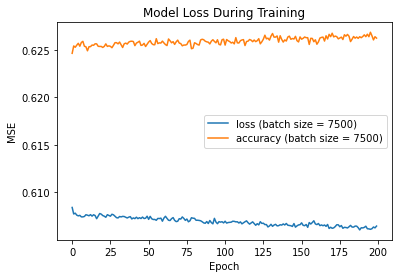

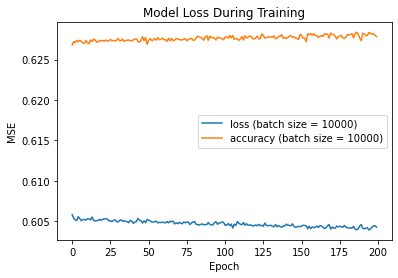

In [93]:
plt.figure()
#plt.plot(NNhistory.history['loss'], label='loss')
#plt.plot(NNhistory.history['accuracy'], label='accuracy')
plt.plot(batch_loss[0], label='loss (batch size = 1000)')
plt.plot(batch_acc[0], label='accuracy (batch size = 1000)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(batch_loss[1], label='loss (batch size = 2000)')
plt.plot(batch_acc[1], label='accuracy (batch size = 2000)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(batch_loss[2], label='loss (batch size = 5000)')
plt.plot(batch_acc[2], label='accuracy (batch size = 5000)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(batch_loss[3], label='loss (batch size = 7500)')
plt.plot(batch_acc[3], label='accuracy (batch size = 7500)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(batch_loss[4], label='loss (batch size = 10000)')
plt.plot(batch_acc[4], label='accuracy (batch size = 10000)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [95]:
# changed epochs to 100 and batch size from 1000-5000
batch_loss = []
batch_acc = []
batches = [1000, 2000, 3000, 4000, 5000]
for batch_size in batches:
    NNhistory = NNmodel.fit(train_X, train_y, epochs = 100, batch_size = batch_size)
    batch_loss.append(NNhistory.history['loss'])
    batch_acc.append(NNhistory.history['accuracy'])

Epoch 1/100
1602/1602 [==============================] - 3s 2ms/step - loss: 0.6198 - accuracy: 0.6149
Epoch 2/100
1602/1602 [==============================] - 3s 2ms/step - loss: 0.6189 - accuracy: 0.6166
Epoch 3/100
1602/1602 [==============================] - 3s 2ms/step - loss: 0.6184 - accuracy: 0.6164
Epoch 4/100
1602/1602 [==============================] - 3s 2ms/step - loss: 0.6187 - accuracy: 0.6166
Epoch 5/100
1602/1602 [==============================] - 4s 2ms/step - loss: 0.6186 - accuracy: 0.6162
Epoch 6/100
1602/1602 [==============================] - 3s 2ms/step - loss: 0.6191 - accuracy: 0.6161
Epoch 7/100
1602/1602 [==============================] - 3s 2ms/step - loss: 0.6192 - accuracy: 0.6157
Epoch 8/100
1602/1602 [==============================] - 4s 2ms/step - loss: 0.6190 - accuracy: 0.6164
Epoch 9/100
1602/1602 [==============================] - 4s 2ms/step - loss: 0.6192 - accuracy: 0.6158
Epoch 10/100
1602/1602 [==============================] - 3s 2ms/step - l

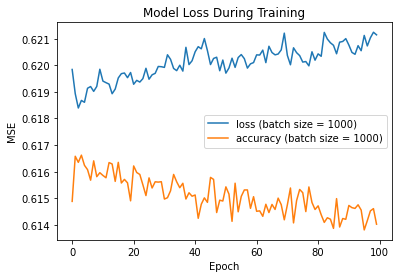

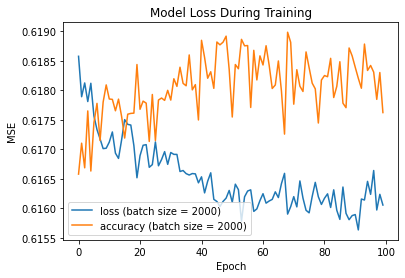

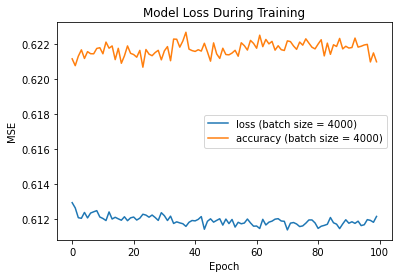

In [98]:
plt.figure()
#plt.plot(NNhistory.history['loss'], label='loss')
#plt.plot(NNhistory.history['accuracy'], label='accuracy')
plt.plot(batch_loss[0], label='loss (batch size = 1000)')
plt.plot(batch_acc[0], label='accuracy (batch size = 1000)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(batch_loss[1], label='loss (batch size = 2000)')
plt.plot(batch_acc[1], label='accuracy (batch size = 2000)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(batch_loss[2], label='loss (batch size = 3000)')
plt.plot(batch_acc[2], label='accuracy (batch size = 3000)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(batch_loss[3], label='loss (batch size = 4000)')
plt.plot(batch_acc[3], label='accuracy (batch size = 4000)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

plt.figure()
plt.plot(batch_loss[4], label='loss (batch size = 5000)')
plt.plot(batch_acc[4], label='accuracy (batch size = 5000)')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend()
plt.show()

In [34]:
# Model 2
#add dropout between layers
train_X.shape
NNmodel = Sequential()
NNmodel.add(Dense(131, input_shape=(131,), activation='relu')) 
NNmodel.add(Dense(65, activation='relu'))
NNmodel.add(Dropout(0.5))
NNmodel.add(Dense(65, activation='relu'))
NNmodel.add(Dropout(0.5))
NNmodel.add(Dense(1, activation='sigmoid'))
NNmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(NNmodel.summary())

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 131)               17292     
_________________________________________________________________
dense_7 (Dense)              (None, 65)                8580      
_________________________________________________________________
dropout (Dropout)            (None, 65)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 65)                4290      
_________________________________________________________________
dropout_1 (Dropout)          (None, 65)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 66        
Total params: 30,228
Trainable params: 30,228
Non-trainable params: 0
__________________________________________________

In [35]:
NNhistory = NNmodel.fit(train_X, train_y, epochs = 200, batch_size = 4000)

Epoch 1/200
401/401 [==============================] - 4s 10ms/step - loss: 1.3154 - accuracy: 0.5608
Epoch 2/200
401/401 [==============================] - 4s 9ms/step - loss: 0.6717 - accuracy: 0.5818
Epoch 3/200
401/401 [==============================] - 4s 9ms/step - loss: 0.6677 - accuracy: 0.5813
Epoch 4/200
401/401 [==============================] - 4s 9ms/step - loss: 0.6632 - accuracy: 0.5820
Epoch 5/200
401/401 [==============================] - 4s 10ms/step - loss: 0.6612 - accuracy: 0.5816
Epoch 6/200
401/401 [==============================] - 4s 10ms/step - loss: 0.6585 - accuracy: 0.5821
Epoch 7/200
401/401 [==============================] - 4s 10ms/step - loss: 0.6569 - accuracy: 0.5822
Epoch 8/200
401/401 [==============================] - 4s 10ms/step - loss: 0.6562 - accuracy: 0.5816
Epoch 9/200
401/401 [==============================] - 4s 9ms/step - loss: 0.6557 - accuracy: 0.5825
Epoch 10/200
401/401 [==============================] - 3s 9ms/step - loss: 0.6549 - a

Accuracy is: 59.620872065238196


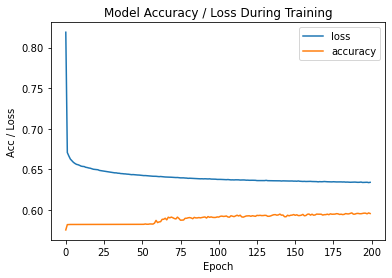

In [36]:
y_nn_pred = NNmodel.predict(test_X)
acc_nn = accuracy_score(test_y,y_nn_pred.round())
print('Accuracy is:', acc_nn*100)

plt.figure()
plt.plot(NNhistory.history['loss'], label='loss')
plt.plot(NNhistory.history['accuracy'], label='accuracy')
plt.title('Model Accuracy / Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Acc / Loss')
plt.legend()
plt.show()

In [38]:
# Model 3 - increased number of layers
NNmodel = Sequential()
NNmodel.add(Dense(200, input_shape= (131,), activation='relu')) # change the output layer size based on https://stackoverflow.com/questions/56299770/units-in-dense-layer-in-keras
NNmodel.add(Dense(100, activation='relu'))
NNmodel.add(Dense(75, activation='relu'))
NNmodel.add(Dense(65, activation='relu'))
NNmodel.add(Dense(65, activation='relu'))
NNmodel.add(Dense(1, activation='sigmoid'))
NNmodel.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(NNmodel.summary())

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 200)               26400     
_________________________________________________________________
dense_17 (Dense)             (None, 100)               20100     
_________________________________________________________________
dense_18 (Dense)             (None, 75)                7575      
_________________________________________________________________
dense_19 (Dense)             (None, 65)                4940      
_________________________________________________________________
dense_20 (Dense)             (None, 65)                4290      
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 66        
Total params: 63,371
Trainable params: 63,371
Non-trainable params: 0
__________________________________________________

In [39]:
NNhistory = NNmodel.fit(train_X, train_y, validation_data=(test_X, test_y),epochs = 200, batch_size = 4000)

Epoch 1/200
401/401 [==============================] - 7s 16ms/step - loss: 0.7343 - accuracy: 0.5710 - val_loss: 0.6580 - val_accuracy: 0.5846
Epoch 2/200
401/401 [==============================] - 6s 14ms/step - loss: 0.6569 - accuracy: 0.5855 - val_loss: 0.6541 - val_accuracy: 0.5884
Epoch 3/200
401/401 [==============================] - 6s 15ms/step - loss: 0.6524 - accuracy: 0.5877 - val_loss: 0.6501 - val_accuracy: 0.5911
Epoch 4/200
401/401 [==============================] - 6s 15ms/step - loss: 0.6480 - accuracy: 0.5920 - val_loss: 0.6477 - val_accuracy: 0.5927
Epoch 5/200
401/401 [==============================] - 6s 15ms/step - loss: 0.6467 - accuracy: 0.5921 - val_loss: 0.6551 - val_accuracy: 0.5894
Epoch 6/200
401/401 [==============================] - 7s 16ms/step - loss: 0.6457 - accuracy: 0.5936 - val_loss: 0.6452 - val_accuracy: 0.5937
Epoch 7/200
401/401 [==============================] - 7s 17ms/step - loss: 0.6434 - accuracy: 0.5955 - val_loss: 0.6444 - val_accuracy:

Accuracy is: 60.441546884566776


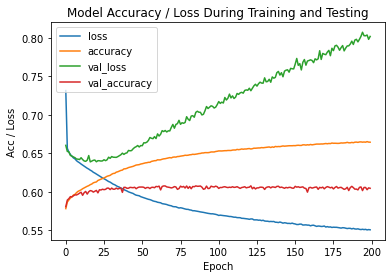

In [195]:
#4 hidden layers (300, 200, 100, 65)
y_nn_pred = NNmodel.predict(test_X)
acc_nn = accuracy_score(test_y,y_nn_pred.round())
print('Accuracy is:', acc_nn*100)

plt.figure()
plt.plot(NNhistory.history['loss'], label='loss')
plt.plot(NNhistory.history['accuracy'], label='accuracy')
plt.plot(NNhistory.history['val_loss'], label='val_loss')
plt.plot(NNhistory.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy / Loss During Training and Testing')
plt.xlabel('Epoch')
plt.ylabel('Acc / Loss')
plt.legend()
plt.show()

Accuracy is: 60.40820776231107


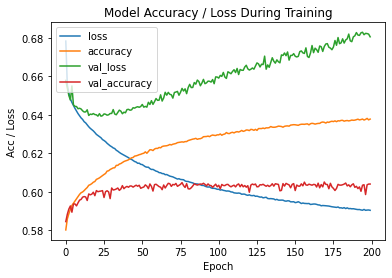

In [41]:
# second run
y_nn_pred = NNmodel.predict(test_X)
acc_nn = accuracy_score(test_y,y_nn_pred.round())
print('Accuracy is:', acc_nn*100)

plt.figure()
plt.plot(NNhistory.history['loss'], label='loss')
plt.plot(NNhistory.history['accuracy'], label='accuracy')
plt.plot(NNhistory.history['val_loss'], label='val_loss')
plt.plot(NNhistory.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy / Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Acc / Loss')
plt.legend()
plt.show()